# SSD300 Evaluation

We'll evaluate an SSD300 on the Pascal VOC 2007 `test` dataset, but note that the `Evaluator` works for any SSD model and any dataset that is compatible with the `DataGenerator`. If you would like to run the evaluation on a different model and/or dataset, the procedure is analogous to what is shown below, you just have to build the appropriate model and load the relevant dataset.

Note: In case you want to evaluate any of the provided trained models, make sure that you build the respective model with the correct set of scaling factors to reproduce the official results.

In [1]:
# Downgrade tensoflow
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Downgrade gast version 0.2.2
!pip install gast==0.2.2

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=5644e6fc4a5a3a5dc045c5610a9049bd94040eaae8c6b1bfb21a017d16bbd8b3
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [3]:
# Downgrade keras version 2.2.4
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 3.5MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [4]:
# Upload the gdrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# Unzip the dataset
!unzip '/content/drive/My Drive/ssd_keras-master/Group-1-PersonDetectionFromTopView/Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_CV/ImagesDir/2_329_948_165304-795795.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165305-665665.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165306-343343.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165306-805805.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165307-525525.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165308-239239.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165309-104104.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165310-165165.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_948_165310-726726.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_949_144536-204204.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_949_144536-539539.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_949_144537-167167.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_950_165311-335335.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_950_165313-543543.jpg  
  inflating: Dataset_CV/ImagesDir/2_329_950_165315-03

In [6]:
# Enter in ssd_keras dir
%cd /content/drive/My Drive/ssd_keras-master/Group-1-PersonDetectionFromTopView

/content/drive/My Drive/ssd_keras-master/Group-1-PersonDetectionFromTopView


In [7]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from skimage.io import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_loss_function.metrics_ssd_loss import SSDLossMetrics
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

Using TensorFlow backend.


In [25]:
# Set a few configuration parameters.
img_height = 300
img_width = 300
n_classes = 1
model_mode = 'inference'  # Change to 'training' for a trained model, else 'inference' for weights

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. You can then of course save the model and next time load the full model directly, without having to build it.

### 1.1. Build the model and load trained weights into it

In [26]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=n_classes,
                mode=model_mode,
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.01,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = '/content/drive/My Drive/weights/VGG_VOC0712_SSD_300x300_iter_120000_subsampled_1_class.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
ssd_loss_metrics = SSDLossMetrics(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss, metrics=[ssd_loss_metrics.f1_m,
                                                                   ssd_loss_metrics.iou_m])

Or

### 1.2. Load a trained model

We set `model_mode` to 'inference' above, so the evaluator expects that you load a model that was built in 'inference' mode. If you're loading a model that was built in 'training' mode, change the `model_mode` parameter accordingly.

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = '/content/drive/My Drive/ssd_keras_model/ssd300_cvdata_epoch-19_loss-1.9390_val_loss-1.5665.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})









Instructions for updating:
Use `tf.cast` instead.




## 2. Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [11]:
dataset = DataGenerator()

# TODO: Set the paths to the dataset here.
Dataset_CV_images_dir      = '/content/Dataset_CV/ImagesDir/'
Dataset_CV_annotations_dir      = '/content/Dataset_CV/AnnotationsDir/'
Dataset_CV_test_image_set_filename     = '/content/Dataset_CV/ImageSet/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background', 'person']

dataset.parse_xml(images_dirs=[Dataset_CV_images_dir],
                  image_set_filenames=[Dataset_CV_test_image_set_filename],
                  annotations_dirs=[Dataset_CV_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Processing image set 'test.txt': 100%|██████████| 5082/5082 [00:10<00:00, 483.91it/s]


## 3. Run the evaluation

Now that we have instantiated a model and a data generator to serve the dataset, we can set up the evaluator and run the evaluation.

The evaluator is quite flexible: It can compute the average precisions according to the Pascal VOC pre-2010 algorithm, which samples 11 equidistant points of the precision-recall curves, or according to the Pascal VOC post-2010 algorithm, which integrates numerically over the entire precision-recall curves instead of sampling a few individual points. You could also change the number of sampled recall points or the required IoU overlap for a prediction to be considered a true positive, among other things. Check out the `Evaluator`'s documentation for details on all the arguments.

In its default settings, the evaluator's algorithm is identical to the official Pascal VOC pre-2010 Matlab detection evaluation algorithm, so you don't really need to tweak anything unless you want to.

The evaluator roughly performs the following steps: It runs predictions over the entire given dataset, then it matches these predictions to the ground truth boxes, then it computes the precision-recall curves for each class, then it samples 11 equidistant points from these precision-recall curves to compute the average precision for each class, and finally it computes the mean average precision over all classes.

In [27]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=8,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    return_average_matches=True,
                    verbose=True)

mean_average_precision, average_matches, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 5082

Matching predictions to ground truth, class 1/1.: 100%|██████████| 700956/700956 [01:19<00:00, 8786.42it/s]
Computing precisions and recalls, class 1/1
Computing average precision, class 1/1
Computing average IOU, class 1/1


## 4. Visualize the results

Let's take a look:

In [28]:
for i in range(1, len(average_matches)):
    print("{:<14}{:<6}{}".format(classes[i], 'IOU', round(average_matches[i], 3)))
print()

for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()

average_recalls = sum(recalls[i])/len(recalls[i])

for i in range(1, len(recalls)):
    print("{:<14}{:<6}{}".format(classes[i], 'Rec', round(average_recalls, 3)))
print()

#print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

person        IOU   0.712

person        AP    0.643

person        Rec   0.887



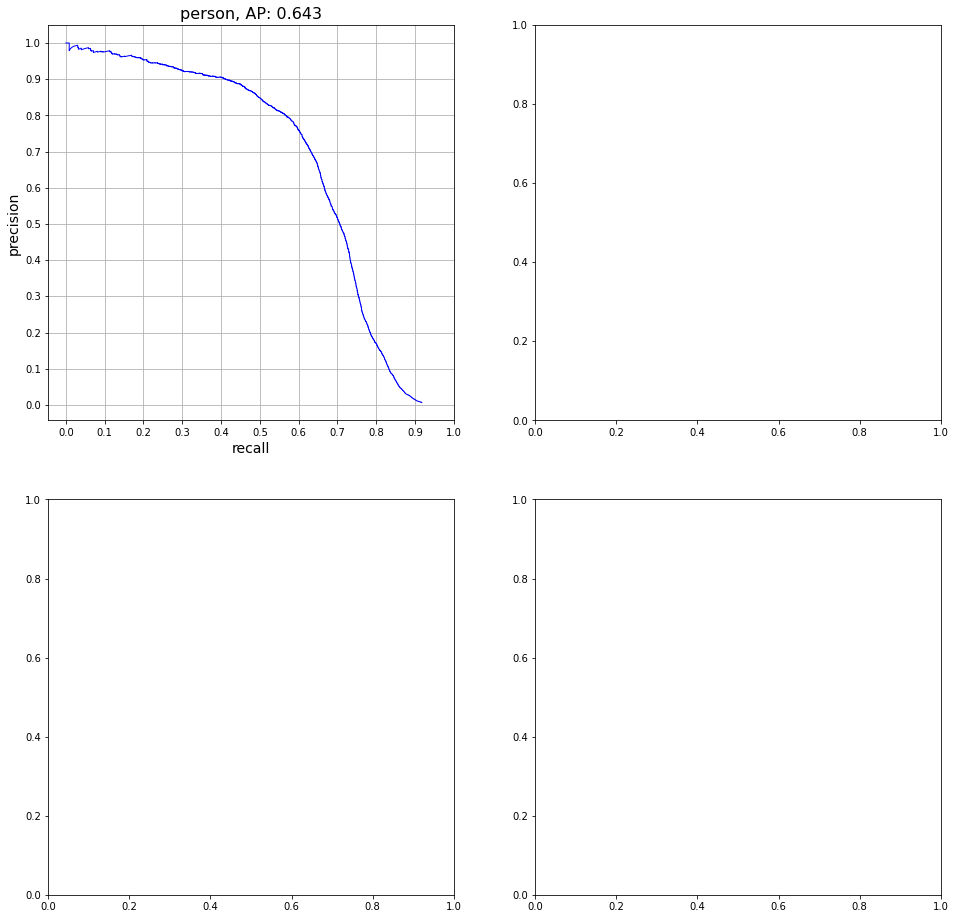

In [29]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

## 5. Advanced use

`Evaluator` objects maintain copies of all relevant intermediate results like predictions, precisions and recalls, etc., so in case you want to experiment with different parameters, e.g. different IoU overlaps, there is no need to compute the predictions all over again every time you make a change to a parameter. Instead, you can only update the computation from the point that is affected onwards.

The evaluator's `__call__()` method is just a convenience wrapper that executes its other methods in the correct order. You could just call any of these other methods individually as shown below (but you have to make sure to call them in the correct order).

Note that the example below uses the same evaluator object as above. Say you wanted to compute the Pascal VOC post-2010 'integrate' version of the average precisions instead of the pre-2010 version computed above. The evaluator object still has an internal copy of all the predictions, and since computing the predictions makes up the vast majority of the overall computation time and since the predictions aren't affected by changing the average precision computation mode, we skip computing the predictions again and instead only compute the steps that come after the prediction phase of the evaluation. We could even skip the matching part, since it isn't affected by changing the average precision mode either. In fact, we would only have to call `compute_average_precisions()` `compute_mean_average_precision()` again, but for the sake of illustration we'll re-do the other computations, too.

In [ ]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

In [ ]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))